In [1]:
import sys
import os

# Get the absolute path to the scripts directory
module_path = os.path.abspath(os.path.join('scripts'))  # Relative to the notebook's location

# Add it to the system path if it's not already there
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from vae import VAE, Sampling
import combine_data_for_DA
import init_gpu
init_gpu.initialize_gpus()

Num GPUs Available:  0


In [5]:
import tensorflow as tf
import model_utils
from train_DICVAE import CVAE

SAVE_PATH = '../models/mnist-svhn/di_vae/'
epochs = 50
vae_model = tf.keras.models.load_model(
        f"{SAVE_PATH}/vae-e{epochs}.keras", compile=False, custom_objects={'Sampling': Sampling, 'CVAE': CVAE})
domain_discriminator = tf.keras.models.load_model(
        f"{SAVE_PATH}/domain_discriminator-e{epochs}.keras", compile=False)

c:\Users\kaush\pyver\py3115\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [ ]:
from mnist import fetch_mnist_dataset
from usps import fetch_usps_dataset
from svhn import fetch_svhn_dataset

# RANDOM_STATE = 42
# NUM_SAMPLES_PER_CLASS = 2000
# DATASET_PATH = '../dataset/USPSdata/Numerals'
x_mnist, y_mnist, _, _ = fetch_mnist_dataset()
x_svhn, y_svhn = fetch_svhn_dataset(dataset_path='../dataset/SVHNdata', split='train')
# x_usps, y_usps = fetch_usps_dataset(DATASET_PATH)

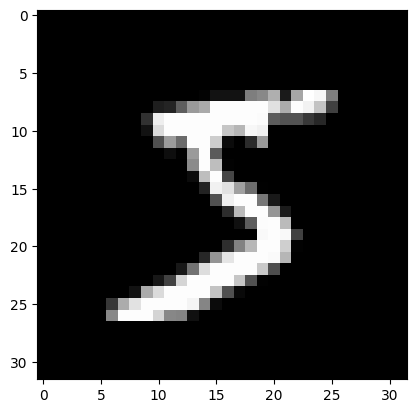

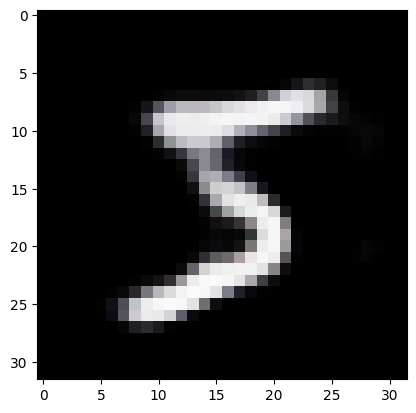

In [6]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(x_mnist[0])


reconstructed_sample, _, _ = vae_model(x_mnist[:1])
plt.figure()
plt.imshow(reconstructed_sample.numpy().reshape(32, 32, 3))

1


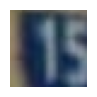

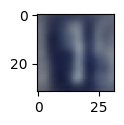

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange


index = randrange(len(x_svhn))
sample = x_svhn[index]
print(y_svhn[index])
plt.figure(figsize=(1, 1))
plt.imshow(sample)
plt.axis('off')


reconstructed_sample, _, _ = vae_model(sample[tf.newaxis, ...])
plt.figure(figsize=(1, 1))
plt.imshow(reconstructed_sample.numpy().reshape(32,32, 3))

(-0.5, 31.5, 31.5, -0.5)

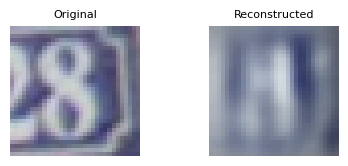

In [40]:
index = np.random.choice(np.where((y_svhn == 9) | (y_svhn == 8))[0])
sample = x_svhn[index]
reconstructed_sample, z_mean, _ = vae_model(sample[tf.newaxis, ...])


# Plot the traversals
plt.figure(figsize=(4, 2))
plt.rcParams.update({'axes.titlesize': 8})
plt.subplot(1, 2, 1)
plt.tight_layout()
plt.title(f"Original")
plt.imshow(sample.reshape(32, 32, 3))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.tight_layout()
plt.title(f"Reconstructed")
plt.imshow(reconstructed_sample.numpy().reshape(32, 32, 3))
plt.axis('off')



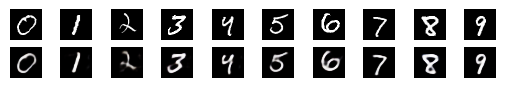

In [41]:
import numpy as np
import matplotlib.pyplot as plt
# select 10 random samples from each class from the mnist dataset

plt.figure()
for i in range(10):
    index = np.random.choice(np.where(y_mnist == i)[0])
    sample = x_mnist[index]
    reconstructed_sample, _, _ = vae_model(sample[tf.newaxis, ...])
    
    # plot as subplots in a 10x10 grid
    plt.subplot(10, 10, i+1)
    plt.imshow(sample)
    plt.axis('off')
    plt.subplot(10, 10, i+11)
    plt.imshow(reconstructed_sample.numpy().reshape(32, 32, 3))
    plt.axis('off')



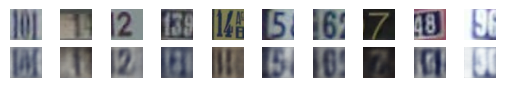

In [42]:
import numpy as np
import matplotlib.pyplot as plt
# select 10 random samples from each class from the mnist dataset

plt.figure()
for i in range(10):
    index = np.random.choice(np.where(y_svhn == i)[0])
    sample = x_svhn[index]
    reconstructed_sample, _, _ = vae_model(sample[tf.newaxis, ...])
    
    # plot as subplots in a 10x10 grid
    plt.subplot(10, 10, i+1)
    plt.imshow(sample)
    plt.axis('off')
    plt.subplot(10, 10, i+11)
    plt.imshow(reconstructed_sample.numpy().reshape(32, 32, 3))
    plt.axis('off')



# Latent Space Analysis

In [43]:
from vae import get_z_mean_embeddings
z_mnist = get_z_mean_embeddings(x_mnist, vae_model)
z_target = get_z_mean_embeddings(x_svhn, vae_model)

In [44]:
# PCA for visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
# Fit PCA on both datasets
pca.fit(np.concatenate((z_mnist, z_target), axis=0))
# Transform both datasets using the fitted PCA
z_mnist_pca = pca.transform(z_mnist)
z_target_pca = pca.transform(z_target)

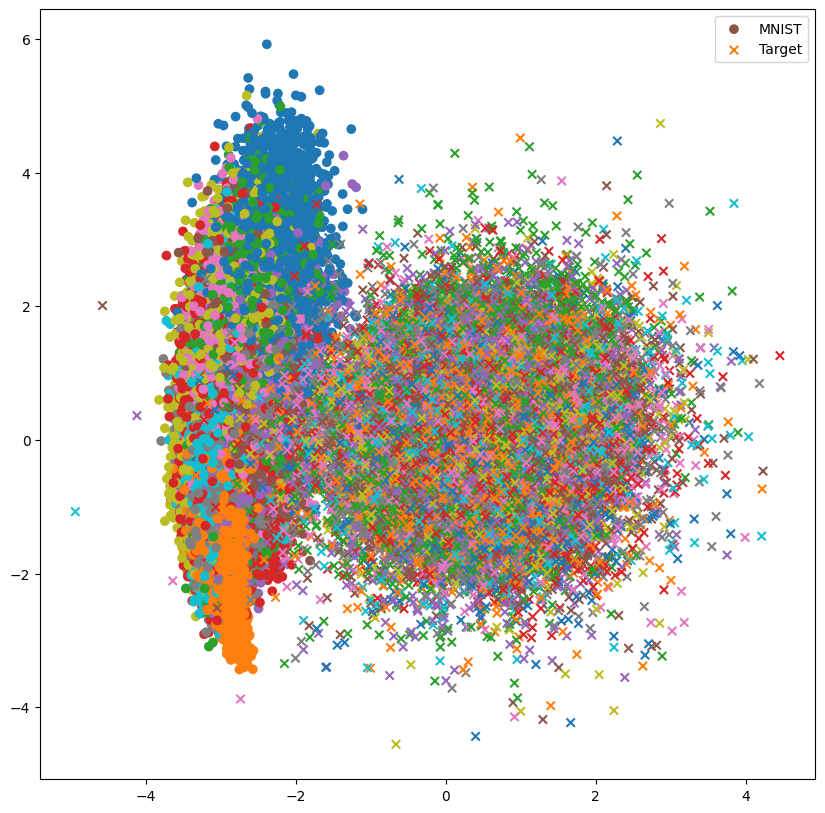

In [45]:
# plot the PCA of latent space of the mnist and usps dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(z_mnist_pca[:, 0], z_mnist_pca[:, 1], c=y_mnist, cmap='tab10', label='MNIST')
plt.scatter(z_target[:, 0], z_target[:, 1], c=y_svhn, cmap='tab10', marker='x', label='Target')

plt.legend()
plt.show()

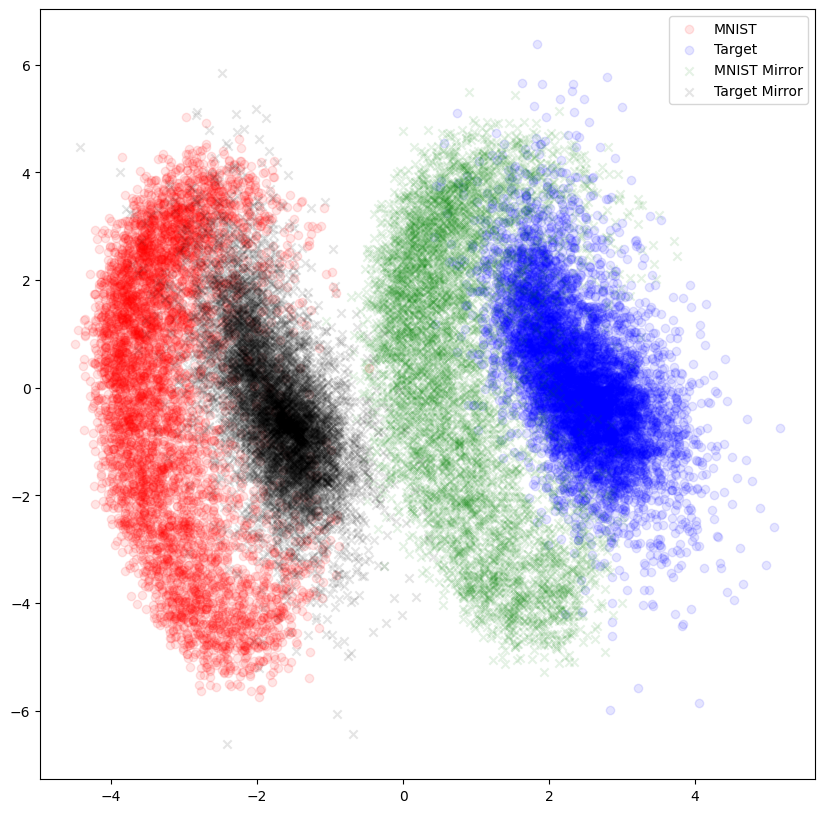

In [46]:
# within one class
# PCA for visualization
import matplotlib.pyplot as plt
from hyperplane import Hyperplane
domain_hyperplane = Hyperplane(domain_discriminator)
w, b = domain_hyperplane.get_hyplerplane_params()


number = 5
# select the index of the class
index = np.where(y_mnist == number)[0]
z_mnist_class = z_mnist[index]

z_dist =  np.dot(z_mnist_class, w) + b
z_mnist_mirror = z_mnist_class - 2 * z_dist[:, np.newaxis] * w[np.newaxis, :]

index = np.where(y_svhn == number)[0]
z_target_class = z_target[index]

z_dist =  np.dot(z_target_class, w) + b
z_target_mirror = z_target_class - 2 * z_dist[:, np.newaxis] * w[np.newaxis, :]

# Fit PCA on both datasets
pca = PCA(n_components=2)
pca.fit(np.concatenate((z_mnist_class, z_target_class), axis=0))
# Transform both datasets using the fitted PCA
z_mnist_class_pca = pca.transform(z_mnist_class)
z_target_class_pca = pca.transform(z_target_class)
z_mnist_mirror_pca = pca.transform(z_mnist_mirror)
z_target_mirror_pca = pca.transform(z_target_mirror)

plt.figure(figsize=(10, 10))
plt.scatter(z_mnist_class_pca[:, 0], z_mnist_class_pca[:, 1], c='red', label='MNIST', alpha=0.1)
plt.scatter(z_target_class_pca[:, 0], z_target_class_pca[:, 1], c='blue', label='Target', alpha=0.1)

plt.scatter(z_mnist_mirror_pca[:, 0], z_mnist_mirror_pca[:, 1], c='green', label='MNIST Mirror', alpha=0.1, marker='x')
plt.scatter(z_target_mirror_pca[:, 0], z_target_mirror_pca[:, 1], c='black', marker='x', label='Target Mirror', alpha=0.1)

plt.legend()
plt.show()


In [47]:
from hyperplane import Hyperplane
domain_hyperplane = Hyperplane(domain_discriminator)
w, b = domain_hyperplane.get_hyplerplane_params()

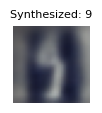

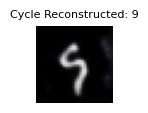

In [69]:
import numpy as np
import matplotlib.pyplot as plt
# number = np.random.choice(y_mnist)
# index = np.random.choice(np.where(y_mnist == number)[0])

# select unseen class
index = np.random.choice(np.where((y_mnist == 9) | (y_mnist == 8))[0])
number = y_mnist[index]

z = z_mnist[index]

# get mirror image
z_dist = np.dot(z, w) + b
z_mirror = z - 2 * z_dist * w

synthetic_sample = vae_model.decode(z_mirror[tf.newaxis, ...])
plt.figure(figsize=(1, 1))
plt.imshow(synthetic_sample.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.title(f"Synthesized: {number}")
plt.show()

# restore the original image
_, _, z_cycle_mirror = vae_model.encode(synthetic_sample.numpy().reshape(1, 32, 32, 3))
# get mirror image
z_cycle_mirror_dist = np.dot(z_cycle_mirror, w) + b
z_cycle = z_cycle_mirror - 2 * z_cycle_mirror_dist * w
reconstructed_original = vae_model.decode(z_cycle)
plt.figure(figsize=(1, 1))
plt.imshow(reconstructed_original.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.title(f"Cycle Reconstructed: {number}")
plt.show()

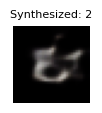

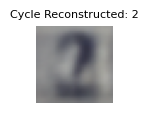

In [75]:
# SVHN to MNIST 
import numpy as np
import matplotlib.pyplot as plt
number = np.random.choice(y_svhn)
index = np.random.choice(np.where(y_svhn == number)[0])

z = z_target[index]

# get mirror image
z_dist = np.dot(z, w) + b
z_mirror = z - 2 * z_dist * w

synthetic_sample = vae_model.decode(z_mirror[tf.newaxis, ...])
plt.figure(figsize=(1, 1))
plt.imshow(synthetic_sample.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.title(f"Synthesized: {number}")
plt.show()

# restore the original image
_, _, z_cycle_mirror = vae_model.encode(synthetic_sample.numpy().reshape(1, 32, 32, 3))
# get mirror image
z_cycle_mirror_dist = np.dot(z_cycle_mirror, w) + b
z_cycle = z_cycle_mirror - 2 * z_cycle_mirror_dist * w
reconstructed_original = vae_model.decode(z_cycle)
plt.figure(figsize=(1, 1))
plt.imshow(reconstructed_original.numpy().reshape(32, 32, 3))
plt.axis('off')
plt.title(f"Cycle Reconstructed: {number}")
plt.show()

In [76]:
# Function to traverse latent space in a specified direction
def traverse_latent_space(z, w_norm, step_size=0.1, steps=10, direction='both'):
    """
    Traverse the latent space along the normalized weight vector.
    
    Parameters:
    - z: Initial latent vector.
    - w_norm: Normalized weight vector (direction of traversal).
    - step_size: Step size for traversal.
    - steps: Number of steps in each direction.
    - direction: Direction of traversal ('forward', 'backward', or 'both').
    
    Returns:
    - np.array: Traversed latent vectors.
    """
    traversals = []
    latent_dim = z.shape[-1]
    if direction == 'both':
        alphas = np.linspace(-steps, steps, num=2*steps+1)  # Symmetric traversal
    elif direction == 'forward':
        alphas = np.linspace(0, steps, num=steps+1)  # Forward only
    elif direction == 'backward':
        alphas = np.linspace(-steps, 0, num=steps+1)  # Backward only
    else:
        raise ValueError("Direction must be 'both', 'forward', or 'backward'.")
    
    for alpha in alphas:
        z_traversed = z + alpha * step_size * w_norm
        traversals.append(z_traversed)
    
    return np.array(traversals).reshape(-1, latent_dim)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


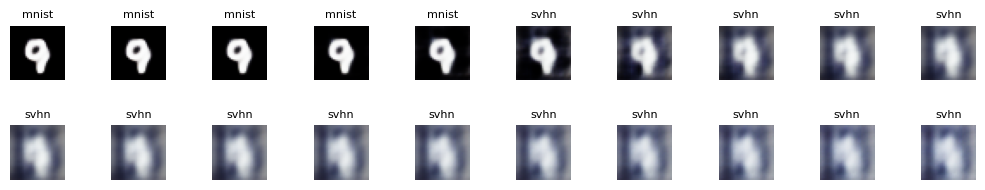

In [118]:
# start from mnist 5 and traverse in the direction of the hyperplane

import numpy as np
import matplotlib.pyplot as plt
# number = np.random.choice(y_mnist)
# index = np.random.choice(np.where(y_mnist == number)[0])

# select unseen class
index = np.random.choice(np.where((y_mnist == 9) | (y_mnist == 8))[0])

z = z_mnist[index]
z_traversals = traverse_latent_space(z, w, step_size=0.6, steps=19, direction='backward')

# reverse the traversal to go in the opposite direction
z_traversals = z_traversals[::-1]

# Decode the traversals
traversed_samples = vae_model.decode(z_traversals)

# check the traversals are in the right direction by using the domain discriminator
domain_logits = domain_discriminator.predict(z_traversals)
domain_probs = tf.nn.softmax(domain_logits)
domain_preds = tf.argmax(domain_probs, axis=1)
# print(domain_probs)


# Plot the traversals
plt.figure(figsize=(10, 10))
for i, sample in enumerate(traversed_samples):
    plt.subplot(10, 10, i+1)
    plt.tight_layout()
    plt.title(f"{'svhn' if domain_preds[i] else 'mnist'}")
    plt.imshow(sample.numpy().reshape(32, 32, 3))
    plt.axis('off')


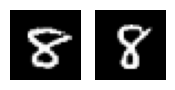

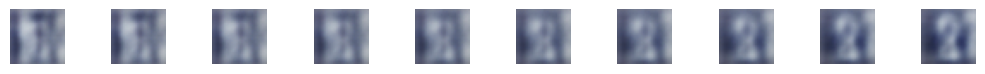

In [82]:
import numpy as np
def get_traversed_z(number: int):
    index = np.random.choice(np.where((y_mnist == number))[0])
    x_sample = x_mnist[index]


    # Encode the sample
    _, _, z = vae_model.encode(x_sample[tf.newaxis, ...])
    z_synthesis = z - 10 * w
    return z_synthesis, x_sample

number = 8
z_1, x_1 = get_traversed_z(number)
z_2, x_2 = get_traversed_z(number)

# interpolate from z_1 to z_2
z_interpolated = np.array([z_1 + alpha * (z_2 - z_1) for alpha in np.linspace(0, 1, num=10)])
interpolated_samples = vae_model.decode(z_interpolated.reshape(-1, 128))



# plot the original z_1 and z_2 in subplots
plt.figure(figsize=(2, 2))
plt.subplot(1, 2, 1)
plt.imshow(x_1.reshape(32, 32, 3))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_2.reshape(32, 32, 3))
plt.axis('off')


# Plot the interpolations
plt.figure(figsize=(10, 10))
for i, sample in enumerate(interpolated_samples):
    plt.subplot(1, 10, i+1)
    plt.tight_layout()
    plt.imshow(sample.numpy().reshape(32, 32, 3))
    plt.axis('off')

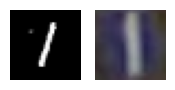

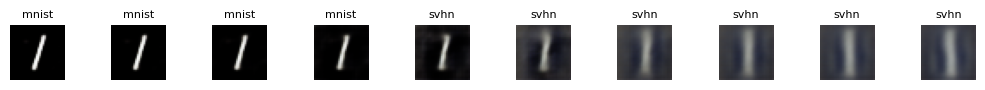

In [107]:
# interpolate between mnist and svhn of same class

number = np.random.choice(range(10))
mnist_index = np.random.choice(np.where(y_mnist == number)[0])


svhn_index = np.random.choice(np.where(y_svhn == number)[0])

mnist_sample = z_mnist[mnist_index]
svhn_sample = z_target[svhn_index]

# interpolate from z_mnist to z_svhn
z_interpolated = np.array([mnist_sample + alpha * (svhn_sample - mnist_sample) for alpha in np.linspace(0, 1, num=10)])
interpolated_samples = vae_model.decode(z_interpolated.reshape(-1, 128))

# plot the original z_mnist and z_svhn in subplots
plt.figure(figsize=(2, 2))
plt.subplot(1, 2, 1)
plt.imshow(x_mnist[mnist_index].reshape(32, 32, 3))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_svhn[svhn_index].reshape(32, 32, 3))
plt.axis('off')
plt.show()
# Plot the interpolations
plt.figure(figsize=(10, 10))
for i, sample in enumerate(interpolated_samples):
    plt.subplot(1, 10, i+1)
    plt.tight_layout()
    plt.title(f"{'svhn' if domain_preds[i] else 'mnist'}")
    plt.imshow(sample.numpy().reshape(32, 32, 3))
    plt.axis('off')
plt.show()
